# Linear regression with the Associated Press

In [this piece from the Associated Press](https://apnews.com/66ac44186b6249709501f07a7eab36da), Nicky Forster combines from the US Census Bureau and the CDC to see how life expectancy is related to actors like unemployment, income, and others. We'll be looking at how they can write sentences like this one: 

> "An increase of 10 percentage points in the unemployment rate in a neighborhood translated to a loss of roughly a year and a half of life expectancy, the AP found."

<p class="reading-options">
  <a class="btn" href="/ap-regression-unemployment/simple-regression-with-census-data-statsmodels-with-formulas">
    <i class="fa fa-sm fa-book"></i>
    Read online
  </a>
  <a class="btn" href="/ap-regression-unemployment/notebooks/Simple regression with census data (statsmodels with formulas).ipynb">
    <i class="fa fa-sm fa-download"></i>
    Download notebook
  </a>
  <a class="btn" href="https://colab.research.google.com/github/littlecolumns/ds4j-notebooks/blob/master/ap-regression-unemployment/notebooks/Simple regression with census data (statsmodels with formulas).ipynb" target="_new">
    <i class="fa fa-sm fa-laptop"></i>
    Interactive version
  </a>
</p>

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **R12221544_SL140.csv:** Employment status by census tract - ACS 2015 5-year, tract level, table B23025
* **R12221544.txt:** Data dictionary for R12221544_SL140.csv - Description of columns and tables
* **R12221550_SL140.csv:** Demographic data by census tract - ACS 2015 5-year, tract level, tables B23025, B06009, B03002, B19013, C17002
* **R12221550.txt:** Data dictionary for R12221550_SL140.csv - Description of columns and tables
* **US_A.CSV:** USALEEP national data - estimates of life expectancy at birth for most of the census tracts in the USA
* **Record_Layout_CensusTract_Life_Expectancy.pdf:** USALEEP data dictionary - None


In [ ]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/ap-regression-unemployment/data/R12221544_SL140.csv.zip -P data
!unzip -n -d data data/R12221544_SL140.csv.zip
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/ap-regression-unemployment/data/R12221544.txt -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/ap-regression-unemployment/data/R12221550_SL140.csv.zip -P data
!unzip -n -d data data/R12221550_SL140.csv.zip
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/ap-regression-unemployment/data/R12221550.txt -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/ap-regression-unemployment/data/US_A.CSV -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/ap-regression-unemployment/data/Record_Layout_CensusTract_Life_Expectancy.pdf -P data

In [48]:
import pandas as pd
import numpy as np

# Keep decimal numbers to 4 decimal places
pd.set_option("display.float_format", '{:,.4f}'.format)
pd.set_option("display.max_columns", 100)

## Reading in our data

We'll start by reading in our datasets (as we must!).

### Life expectancy data

The first dataset is [USALEEP](https://www.cdc.gov/nchs/nvss/usaleep/usaleep.html), the U.S. Small-area Life Expectancy Estimates Project. It's from the National Center for Health Statistics at the CDC.

We're going to rename a few columns so they make a little more sense. The columns themselves aren't too complicated, mostly pointing out the census tracts and the life expectancy.

In [60]:
life_expec = pd.read_csv("data/US_A.CSV")
life_expec.columns = ['tract_id', 'STATE2KX','CNTY2KX', 'TRACT2KX', 'life_expectancy', 
                      'life_expectancy_std_err', 'flag']
life_expec.head()

,tract_id,STATE2KX,CNTY2KX,TRACT2KX,life_expectancy,life_expectancy_std_err,flag
0,1001020100,1,1,20100,73.1000,2.2348,3
1,1001020200,1,1,20200,76.9000,3.3453,3
2,1001020400,1,1,20400,75.4000,1.0216,3
3,1001020500,1,1,20500,79.4000,1.1768,1
4,1001020600,1,1,20600,73.1000,1.5519,3


`flag` sounds a little mysterious and scary, but it's just whether the numbers were observed or predicted.

### Unemployment Data

For unemployment, we'll be using data from the Census. You can get unemployment measures from a lot of places in the US government, so the Census Bureau actually [publishes data on which ones you should use](https://www.census.gov/topics/employment/labor-force/guidance.html). In our case we're going to collect unemployment data from the American Community Survery, for the 5-year period nearest to our life expectancy dataset.

We'll be using Table B23025005, Employment Status for the Population 16 Years and Over. Take a look at [the codebook](https://www.socialexplorer.com/data/ACS2015_5yr/metadata/?ds=ACS15_5yr&var=B23025005) for more details. We're only reading in a few columns to keep things looking clean.

In [63]:
columns = {
    'Geo_FIPS': 'Geo_FIPS',
    'ACS15_5yr_B23025001': 'total_pop',
    'ACS15_5yr_B23025005': 'unemployed'
}
employment = pd.read_csv("data/R12221544_SL140.csv", usecols=columns.keys(), encoding='latin-1')

employment = employment.rename(columns=columns)
employment.head()

,Geo_FIPS,total_pop,unemployed
0,1001020100,1554,54
1,1001020200,1731,116
2,1001020300,2462,91
3,1001020400,3424,216
4,1001020500,8198,221


Since the important thing is _percent_ unemployed, not just how many people are in an area, we'll need to do a little calculation.

> **Note that I'm multiplying by 100 here** - if you have a litle extra time, try running this notebook on your own with a 0-1.0 percentage instead of the 0-100 version.

In [66]:
employment['pct_unemployment'] = employment['unemployed'] / employment['total_pop'] * 100
employment.head()

,Geo_FIPS,total_pop,unemployed,pct_unemployment
0,1001020100,1554,54,3.4749
1,1001020200,1731,116,6.7013
2,1001020300,2462,91,3.6962
3,1001020400,3424,216,6.3084
4,1001020500,8198,221,2.6958


### Demographic data

The other dataset we're using is also from the Census Bureau's American Community Survey. It's a collection of many more columns with very, very long names and very, very mysterious codes. The tables include:

* [B03002](https://censusreporter.org/tables/B03002/): Hispanic or Latino Origin by Race
* [B06009](https://censusreporter.org/tables/B06009/): Place of Birth by Educational Attainment in the United States
* [C17002](https://censusreporter.org/tables/C17002/): Ratio of Income to Poverty Level
* [B19013](https://censusreporter.org/tables/B19013/): Median Household Income

Again, we're only picking a few columns to read in. Generally they're the raw count of certain populations, as well as the total population counted of each table.

In [67]:
columns = {
    'Geo_FIPS': 'Geo_FIPS',
    'ACS15_5yr_B03002001': 'race_table_total',
    'ACS15_5yr_B03002004': 'black',
    'ACS15_5yr_B03002003': 'white',
    'ACS15_5yr_B03002012': 'hispanic',
    'ACS15_5yr_B06009001': 'edu_table_total',
    'ACS15_5yr_B06009002': 'less_than_hs',
    'ACS15_5yr_C17002004': 'poverty_100_124',
    'ACS15_5yr_C17002005': 'poverty_125_149',
    'ACS15_5yr_C17002001': 'poverty_table_total',
    'ACS15_5yr_B19013001': 'income'
}        
census = pd.read_csv("data/R12221550_SL140.csv", usecols=columns.keys(), encoding='latin-1')
census = census.rename(columns=columns)
census.head()

,Geo_FIPS,race_table_total,white,black,hispanic,edu_table_total,less_than_hs,poverty_table_total,poverty_100_124,poverty_125_149,income
0,1001020100,1948,1703,150,17,"1,243.0000",184.0000,1948,81,101,"61,838.0000"
1,1001020200,2156,872,1149,17,"1,397.0000",356.0000,1983,232,58,"32,303.0000"
2,1001020300,2968,2212,551,0,"2,074.0000",221.0000,2968,148,207,"44,922.0000"
3,1001020400,4423,3662,162,464,"2,899.0000",339.0000,4423,141,182,"54,329.0000"
4,1001020500,10763,7368,2674,80,"6,974.0000",310.0000,10563,256,1064,"51,965.0000"


We'll again convert these **raw population numbers into percentages** - what percent of people are certain races? What percent of people have not finished high school?

In [68]:
census_features = pd.DataFrame({
    'Geo_FIPS': census.Geo_FIPS,
    'pct_black': census.black / census.race_table_total * 100,
    'pct_white': census.white / census.race_table_total * 100,
    'pct_hispanic': census.hispanic / census.race_table_total * 100,
    'pct_less_than_hs': census.less_than_hs / census.edu_table_total * 100,
    'pct_under_150_poverty': (census.poverty_100_124 + census.poverty_125_149) / census.poverty_table_total * 100,
    'income': census.income,
})
census_features.head()

,Geo_FIPS,pct_black,pct_white,pct_hispanic,pct_less_than_hs,pct_under_150_poverty,income
0,1001020100,7.7002,87.4230,0.8727,14.8029,9.3429,"61,838.0000"
1,1001020200,53.2931,40.4453,0.7885,25.4832,14.6243,"32,303.0000"
2,1001020300,18.5647,74.5283,0.0000,10.6557,11.9609,"44,922.0000"
3,1001020400,3.6627,82.7945,10.4906,11.6937,7.3027,"54,329.0000"
4,1001020500,24.8444,68.4567,0.7433,4.4451,12.4964,"51,965.0000"


## Merge the data

To perform our regression, we need all of our data in **a single dataframe**. Fortunately these dataframes all keep track of census tracks with [FIPS codes](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt), unique geographic codes that we can rely on to merge our datasets.

In [72]:
merged = life_expec.merge(employment, left_on='tract_id', right_on='Geo_FIPS')
merged = merged.merge(census_features, left_on='Geo_FIPS', right_on='Geo_FIPS')
merged.head()

,tract_id,STATE2KX,CNTY2KX,TRACT2KX,life_expectancy,life_expectancy_std_err,flag,Geo_FIPS,total_pop,unemployed,pct_unemployment,pct_black,pct_white,pct_hispanic,pct_less_than_hs,pct_under_150_poverty,income
0,1001020100,1,1,20100,73.1000,2.2348,3,1001020100,1554,54,3.4749,7.7002,87.4230,0.8727,14.8029,9.3429,"61,838.0000"
1,1001020200,1,1,20200,76.9000,3.3453,3,1001020200,1731,116,6.7013,53.2931,40.4453,0.7885,25.4832,14.6243,"32,303.0000"
2,1001020400,1,1,20400,75.4000,1.0216,3,1001020400,3424,216,6.3084,3.6627,82.7945,10.4906,11.6937,7.3027,"54,329.0000"
3,1001020500,1,1,20500,79.4000,1.1768,1,1001020500,8198,221,2.6958,24.8444,68.4567,0.7433,4.4451,12.4964,"51,965.0000"
4,1001020600,1,1,20600,73.1000,1.5519,3,1001020600,2855,190,6.6550,11.9190,72.9161,13.0615,17.4873,10.8543,"63,092.0000"


## Running the regression

Using the `statsmodels` package, we'll run a linear regression to find the relationship between **life expectancy** and our **calculated columns**. Note that we're using the **formula method** of writing a regression instead of the dataframes method. I find it both more readable and more useable than the dataframes method.

> Python note: I'm also using a [multiline string](https://stackoverflow.com/posts/10660443/revisions) which is started and ended using three quotation marks. Multi-line strings and formulas are a match made in heaven!

In [74]:
import statsmodels.formula.api as smf

model = smf.ols("""
    life_expectancy ~ pct_black + pct_white + pct_hispanic + pct_less_than_hs
        + pct_under_150_poverty + income + pct_unemployment
""", data=merged)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     8997.
Date:                Thu, 12 Dec 2019   Prob (F-statistic):               0.00
Time:                        21:50:03   Log-Likelihood:            -1.6208e+05
No. Observations:               65656   AIC:                         3.242e+05
Df Residuals:                   65648   BIC:                         3.243e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                81.2365      0.122    665.628      0.000      80.997      81.476
pct_black                -0.0666      0.001    -56.960      0.000      -0.069      -0.064
pct_white                -0.0386      0.001    -36.707      0.000      -0.041      -0.037
pct_hispanic              0.0131      0.001     10.298      0.000       0.011       0.016
pct_less_than_hs         -0.0862      0.002    -48.979      0.000      -0.090      -0.083
pct_under_150_poverty    -0.0596      0.003    -21.738      0.000      -0.065      -0.054
income                 4.825e-05    5.8e-07     83.217      0.000    4.71e-05    4.94e-05
pct_unemployment         -0.1490      0.004    -33.408      0.000      -0.158      -0.140
==============================================================================
Omnibus:                     2114.193   Durbin-Watson:                   1.520
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4788.035
Skew:                           0.183   Prob(JB):                         0.00
Kurtosis:                       4.271   Cond. No.                     7.06e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It's a lot to take in, so I'll zero us in on the important parts:
    
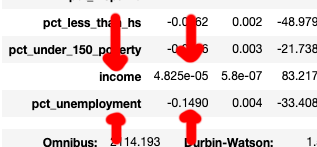

The coefficient for `pct_unemployment` is -0.15, which means **"for every percentage point increase in unemployment, life expectancy drops 0.15 years."** While this might be _correct_ it unfortunately sounds very stupid.

Income's coefficient is rather unfortunate, too. "For every extra dollar in median income, life expectancy goes up 0.00004825 years." No thanks! Individual dollars don't really make sense here.

Instead, it'd be nice to say something like **"for every ten point increase of unemployment,"** or **"for every 10k increase in income."** If we were using the dataframes version of regression, we'd create new columns, maybe something like this:

```python
merged['income_10k'] = merged.income / 10000
merged['unemployment_pct_10pts'] = merged.pct_unemployment / 10
```

Since we're using the formulas method, though, we can do the division right in the regression!

In [75]:
model = smf.ols("""
    life_expectancy ~ 
        pct_black 
        + pct_white 
        + pct_hispanic 
        + pct_less_than_hs 
        + pct_under_150_poverty 
        + np.divide(income, 10000)
        + np.divide(pct_unemployment, 10)
""", data=merged)

results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     8997.
Date:                Thu, 12 Dec 2019   Prob (F-statistic):               0.00
Time:                        21:50:50   Log-Likelihood:            -1.6208e+05
No. Observations:               65656   AIC:                         3.242e+05
Df Residuals:                   65648   BIC:                         3.243e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          81.2365      0.122    665.628      0.000      80.997      81.476
pct_black                          -0.0666      0.001    -56.960      0.000      -0.069      -0.064
pct_white                          -0.0386      0.001    -36.707      0.000      -0.041      -0.037
pct_hispanic                        0.0131      0.001     10.298      0.000       0.011       0.016
pct_less_than_hs                   -0.0862      0.002    -48.979      0.000      -0.090      -0.083
pct_under_150_poverty              -0.0596      0.003    -21.738      0.000      -0.065      -0.054
np.divide(income, 10000)            0.4825      0.006     83.217      0.000       0.471       0.494
np.divide(pct_unemployment, 10)    -1.4900      0.045    -33.408      0.000      -1.577      -1.403
==============================================================================
Omnibus:                     2114.193   Durbin-Watson:                   1.520
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4788.035
Skew:                           0.183   Prob(JB):                         0.00
Kurtosis:                       4.271   Cond. No.                         792.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**That's much much nicer!** Unemployment now has a -1.49 coefficient, which (surprise!) leads us right back to the [original article](https://apnews.com/66ac44186b6249709501f07a7eab36da):

> An increase of 10 percentage points in the unemployment rate in a neighborhood translated to a loss of roughly a year and a half of life expectancy, the AP found. 

Additionally, the negative coefficient for `pct_less_than_hs` is the source of this line:

> A neighborhood where more adults failed to graduate high school had shorter predicted longevity.

Even though we accomplished this pretty quickly in very few lines of code, the actual process at the Associated Press was somewhat more complicated. They didn't just throw a bunch of columns in a regression!

Stats-wise, the AP did things like examined other columns that didn't meet a p-value threshold, and reasoned about [collinearity](http://www.stat.tamu.edu/~hart/652/collinear.pdf) between variables different. For domain expertise, they included a threshold for poverty that's actually _above_ the poverty line. This is due to the way that Medicaid provides health insurance to people in low-income households.

## Review

In this exercise, we reproduced [an article from the Associated Press](https://apnews.com/66ac44186b6249709501f07a7eab36da) that analyzed life expectancy and demographic information from the census. They used a linear regression to find the relationship between census tract qualities like unemployment, education, race, and income and how long people live.

After running the regression once, we ran it a second time to get numbers that were **more human and easier to use in a story**, like a "1.5 year decrease in life expectancy" as opposed to a 0.15-year or 8-week decrease. We also used the **formula version** of a statsmodels linear regression to perform those calculations in the regression with `np.divide`.

## Discussion topics

TODO

> Translate some of your coefficients into the form **"every X percentage point change in unemployment translates to a Y change in life expectancy."** Do this with numbers that are meaningful, and in a way that is easily understandable to your reader.
> A 1 percentage point increase in unemployment translates to a 0.15 year decrease in life expectancy
>
> A 10 percentage point increase in unemployment translates to a 1.5 year decrease in life expectancy
> Do your numbers seem off? Things too big, or too small? Make sure your percentages are percentage points between 0 and 100, not fractions between 0 and 1.